# Data Preprocessing

Il dataset, prima di tutto, va opportunamente elaborato per occuparsi di eventuali standardizzazioni e feature da eliminare. Inoltre dovremo separare i dati per ottenere un training e un test set.
Gli step che seguiremo saranno i seguenti:
1. Caricare i dati
2. Eliminare le features ridondanti o inutili
3. Standardizzare i dati
4. Dividere il dataset in training e test set
5. Creazione di tensori e dataloader

### Definizione variabili

Per velocizzare il processo di prova di nuovi modelli, vengono dichiarate qui alcune `variabili` che verranno utilizzate successivamente nel codice.

In [1]:
# Lunghezza percentuale del dataset di allenamento, il test è definito di conseguenza
len_percentage_train = 80 / 100

classes = ("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral")

### Librerie

Allo stesso modo si inseriscono qui tutte le `librerie` usate per il progetto

In [2]:
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import albumentations as A
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
IN_COLAB = 'google.colab' in sys.modules

### Caricamento dei dati

Tramite `pandas` e il dataset fornito in .csv, carichiamo i dati all'interno di un dataset.

La variabile `IN_COLAB` permette al sistema di distinguere se il codice è eseguito in locale o all'interno di _Google Colab_. 

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    fer2013 = pd.read_csv('/content/drive/My Drive//Università//Deep Learning//emotion-cnn//files//fer2013.csv')
else:
    fer2013 = pd.read_csv('files/fer2013.csv')
fer2013

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


### Eliminazione della colonna "Usage"

All'interno del dataset è presente una colonna `Usage`, che è stata utilizzata durante la challenge da cui questo dataset è stato preso. Nel nostro caso non è utile, quindi la eliminiamo, utilizzando il metodo `.drop`.

In [4]:
print(list(fer2013.columns))
fer2013 = fer2013.drop(['Usage'], axis=1)
print(list(fer2013.columns))

['emotion', 'pixels', 'Usage']
['emotion', 'pixels']


### Da stringa di pixels a `np.array`
In questo passaggio elaboriamo il campo `pixel` del dataset. Di default questo è una stringa di numeri separati da uno spazio.

Per trasformare questa stringa in un array di `numpy`:
1. Separiamo tutti i numeri con `.split(' ')`, che vengono subito inseriti in un array di `numpy`
2. L'array viene trasformato in una matrice 48x48: a questo punto i numero non verranno più considerati come stringhe, ma come `float32`
3. Tutti i valori vengono divisi per 255, in modo da avere solo numeri compresi da 0 e 1.

In [5]:
fer2013.pixels = fer2013.pixels.apply(lambda x: np.array(x.split(' ')).reshape(1, 48, 48).astype('float32')/255)

### Mostrare le immagini
Funzione per visualizzare le immagini

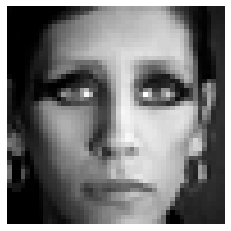

In [6]:
def show(img):
    img = img * 255
    plt.axis("off")
    plt.imshow(img, cmap = 'gray')
    plt.show()

show(fer2013.pixels[4][0])

### Salvataggio del dataset normalizzato
Tramite un oggetto `pickle`, salviamo il dataset processato. In questo modo non dovremo rieseguire i blocchi di codici precedenti, che sono computazionalmente pesanti.

In [7]:
if IN_COLAB:
    fer2013.to_pickle("/content/drive/My Drive/Università/Deep Learning/emotion-cnn/files/fer_norm.pkl")
else:
    fer2013.to_pickle("files/fer_norm.pkl")

### Caricamento del dataset normalizzato

In [8]:
if IN_COLAB:
    fer2013 = pd.read_pickle("/content/drive/My Drive/Università/Deep Learning/emotion-cnn/files/fer_norm.pkl")
else:
    fer2013 = pd.read_pickle("files/fer_norm.pkl")

fer2013

,emotion,pixels
0,0,"[[[0.27450982, 0.3137255, 0.32156864, 0.282352..."
1,0,"[[[0.5921569, 0.5882353, 0.5764706, 0.60784316..."
2,2,"[[[0.90588236, 0.83137256, 0.6117647, 0.643137..."
3,4,"[[[0.09411765, 0.1254902, 0.14117648, 0.117647..."
4,6,"[[[0.015686275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
35882,6,"[[[0.19607843, 0.14117648, 0.06666667, 0.08627..."
35883,3,"[[[0.69803923, 0.68235296, 0.6745098, 0.678431..."
35884,0,"[[[0.06666667, 0.06666667, 0.0627451, 0.090196..."
35885,3,"[[[0.11764706, 0.10980392, 0.10980392, 0.11372..."


### Divisione del dataset in training e test set

La seguente divisione produrrà due dataset:
1. Il training set, rapprensentatnte l'80% del dataset iniziale
2. Il test set set, rappresentatnte del 20% del dataset iniziale

In [9]:
train_set, test_set = np.split(fer2013, [ int(len_percentage_train * len(fer2013)) ] )
test_set.reset_index(inplace=True, drop=True) # Resettiamo gli index per semplificare le operazioni successive

print("Lunghezza percentuale di:")
print("train_set: {:.0%}:".format( len(train_set) / len(fer2013) ))
print("test_set: {:.0%}".format( len(test_set) / len(fer2013) ))

Lunghezza percentuale di:
train_set: 80%:
test_set: 20%


## Data augmentation
Dopo svariati test, abbiamo constatato che ci fosse bisogno di aumentare il volume di dati, in quanto, come visibile nel blocco di codice successivo, il numero di dati disponibile per emozione non è lo stesso per tutte.

Abbiamo provato sia a generare le immagini direttamente durante il training, dentro le epoche, sia prima del training, portanto tutte le classi ad avere lo stesso numero di dati. 

Nel nostro caso, il metodo più efficace si è rivelato quello di generare le immagini **prima** del training. Come livello comune abbiamo scelto quello della classe `Happy`, che contava più immagini di tutte.

In [10]:
# Printiamo il numero di dati per ogni classe, salavando il nuero di dati più grande
max_elements = 0

for i, emote in enumerate(classes):
    print(emote, "-->", len(train_set[train_set.emotion == i]))

    if len(train_set[train_set.emotion == i]) > max_elements:
        max_elements = len(train_set[train_set.emotion == i])

Angry --> 3995
Disgust --> 436
Fear --> 4097
Happy --> 7215
Sad --> 4830
Surprise --> 3171
Neutral --> 4965


Definiamo quindi questo tipo trasformazione:

Flip dell'immagine sull'asse y ➝ Randomizzazione della luminoistà e del contrasto ➝ Rotazione dell'immagine di un angolo compreso tra -30° e 30°

In [11]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5), # Flip dell'immagine sull'asse y (immagine specchiata), con probabilità del 50% 
    A.RandomBrightnessContrast(p=0.3), # Randomizzazione della luminosità e del contrasto dell'immagine, con probabilità del 30%
    A.Rotate(limit = 30) # L'immagine viene ruotata in un range che va da un angolo di -30 a 30 gradi
])

def generate_data(elements_to_generate, transform_seq, emotion, images):
    i = 0
    result = []
    while i < elements_to_generate:
        for image in images:
            if i >= elements_to_generate:
                break
            
            transformed = transform_seq(image=image)
            transformed_image = transformed["image"]
            em_img = emotion,transformed_image
            result.append(em_img)
            i+=1
    
    return result

Le immagini passeranno attraverso la funzione `generate_data`, che tramite `transform_seq`, trasforma un numero di immagini tale da arrivare al livello di `Happy`.

I nuovi dati generati vengono concatenati al train_set

In [12]:
new_data = []
for idx, emotion in enumerate(classes):
    train_set = pd.concat([
        train_set,
        pd.DataFrame(
            generate_data(max_elements - len(train_set[train_set.emotion == idx]), transform_train, idx, train_set[train_set.emotion == idx].pixels),
            columns=["emotion", "pixels"]
        )
    ])

train_set = train_set.reset_index(drop=True)

### Analisi finale del dataset
A questo punto la quantità di dati di train sono tutti allo stesso livello

In [13]:
freq = [0] * 7

for image in train_set.emotion:
    freq[ image ] += 1

print("train", freq)

freq = [0] * 7

for image in test_set.emotion:
    freq[ image ] += 1

print("test",freq)

train [7215, 7215, 7215, 7215, 7215, 7215, 7215]
test [958, 111, 1024, 1774, 1247, 831, 1233]


### Creazione tensori e dataloader
Partendo dagli array numpy, contenenti le immagini, dividiamo l'input e l'output per il training e il test set, che successivamente utilizziamo per creade il `TensorDataset`.

Tramite il `TensorDataset`, creiamo i `DataLoader`: utilizziamo un batch da 4, droppando l'ultimo batch per evitare incogruenze durante il training
Impostiamo anche il parametro `shuffle` a `True`: non ha importanza l'ordine con cui i dati vengono forniti al modello. È anche necessario visto che i nuovi dati generati, concatenati al dataset, sono stati inseriti in ordine di "emozione".

In [14]:
train_x, train_y = torch.tensor(train_set.pixels), torch.tensor(train_set.emotion)
test_x, test_y = torch.tensor(test_set.pixels), torch.tensor(test_set.emotion)

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, drop_last=True, batch_size=4)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, drop_last=True, batch_size=4)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

<ipython-input-14-d123a86fbcf4>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_x, train_y = torch.tensor(train_set.pixels), torch.tensor(train_set.emotion)


torch.Size([50505, 1, 48, 48])
torch.Size([50505])
torch.Size([7178, 1, 48, 48])
torch.Size([7178])


# Modello con CNN

### VGG16 Schema

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg" alt="drawing" width="500"/>

### Schema modello per FER2013

[Tesi d'esempio sul FER2013](https://arxiv.org/pdf/2010.01301.pdf)

### Definizione del modello

In [52]:
class Emotion_CNN(torch.nn.Module):
    def __init__(self):
        super(Emotion_CNN, self).__init__()
    
        self.num_input_conv = 1
        self.num_filter_conv1 = 8
        self.num_filter_conv2 = 16
        self.num_filter_conv3 = 32

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(self.num_input_conv, self.num_filter_conv1, kernel_size=3, stride=1, padding=1),        
            torch.nn.BatchNorm2d(self.num_filter_conv1),
            torch.nn.MaxPool2d(kernel_size=3, stride=1),
            torch.nn.ReLU(),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(self.num_filter_conv1, self.num_filter_conv2, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(self.num_filter_conv2),
            torch.nn.MaxPool2d(kernel_size=3, stride=1),
            torch.nn.ReLU(),
            # Defining another 2D convolution layer
            torch.nn.Conv2d(self.num_filter_conv2, self.num_filter_conv3, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(self.num_filter_conv3),
            torch.nn.MaxPool2d(kernel_size=6, stride=2),
            torch.nn.ReLU(),
        )
 
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(10368, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7),
        )
 
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

[Sito da cui ho preso il modello](https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/)

### Istanza del modello

Nel blocco successivo impostiamo il device per il modello, in base alle disponibilità della macchina.
Per l'optimizer abbiamo scelto `Adam`: il `learning rate` migliore, nel nostro caso, sembra essere 0.00001.

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Emotion_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()
device

device(type='cuda')

### Definizione di Training e Validation

In [49]:
train_losses = []
valid_losses = []

def Train():
    running_loss = .0
    model.train()

    for inputs,labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().data.numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(test_loader)
        valid_losses.append(valid_loss.detach().cpu().data.numpy())
        print(f'valid_loss {valid_loss}')

### Allenamento e Validazione del modello

In questa fase andiamo ad allenare e successivamente validare il modello per ogni epoca

In [54]:
epochs = 10

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

epochs 1/10
train_loss 1.6067548990249634
valid_loss 1.4593002796173096
epochs 2/10
train_loss 1.372204303741455
valid_loss 1.4169542789459229
epochs 3/10
train_loss 1.2498656511306763
valid_loss 1.3110214471817017
epochs 4/10
train_loss 1.1531370878219604
valid_loss 1.2894176244735718
epochs 5/10
train_loss 1.0742335319519043
valid_loss 1.2592802047729492
epochs 6/10
train_loss 1.0027941465377808
valid_loss 1.2703837156295776
epochs 7/10
train_loss 0.9437257051467896
valid_loss 1.2331242561340332
epochs 8/10
train_loss 0.8855607509613037
valid_loss 1.238628625869751
epochs 9/10
train_loss 0.832775890827179
valid_loss 1.2393863201141357
epochs 10/10
train_loss 0.7806084752082825
valid_loss 1.2124053239822388


### Visualizzazione grafico della loss

Dal grafico risulatante dal blocco di codice qui sotto, abbiamo sempre osservato dell'overfitting, forse dovuto al numero elevato di immagini modificate nella fase di data augmentation.

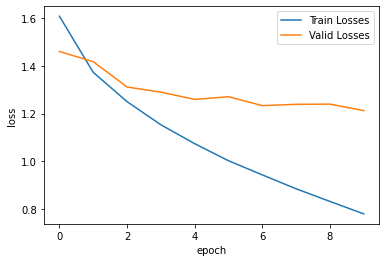

In [55]:
loss_df = pd.DataFrame( {'Train Losses':train_losses, 'Valid Losses':valid_losses }, index=list(range(len(train_losses))) )

loss_df=loss_df.astype(float)

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

### Salvataggio dello stato di modello
Per evitare di dover allenare nuovamente un certo modello, abbiamo deciso di salvare il suo stato, in modo tale da poterlo ricaricare successivamente quando necessario.

In [57]:
if IN_COLAB:
    torch.save(model.state_dict(), '/content/drive/My Drive/Università/Deep Learning/emotion-cnn/files/model_2021-12-08.pth')
else:
    torch.save(model.state_dict(), 'files/modello_ottimo_55acc.pth')

### Caricamento dello stato di modello

In [45]:
# Attenzione: "model" deve essere della stessa classe dell'oggetto che si aveva salvato
model.load_state_dict(torch.load('files/modello_ottimo.pth', map_location=torch.device('cuda')))

RuntimeError: Error(s) in loading state_dict for Emotion_CNN:
	Missing key(s) in state_dict: "cnn_layers.1.weight", "cnn_layers.1.bias", "cnn_layers.1.running_mean", "cnn_layers.1.running_var", "cnn_layers.5.weight", "cnn_layers.5.bias", "cnn_layers.5.running_mean", "cnn_layers.5.running_var", "cnn_layers.8.weight", "cnn_layers.8.bias", "cnn_layers.9.weight", "cnn_layers.9.bias", "cnn_layers.9.running_mean", "cnn_layers.9.running_var", "linear_layers.2.weight", "linear_layers.2.bias". 
	Unexpected key(s) in state_dict: "cnn_layers.2.weight", "cnn_layers.2.bias", "cnn_layers.2.running_mean", "cnn_layers.2.running_var", "cnn_layers.2.num_batches_tracked", "cnn_layers.6.weight", "cnn_layers.6.bias", "cnn_layers.6.running_mean", "cnn_layers.6.running_var", "cnn_layers.6.num_batches_tracked". 
	size mismatch for linear_layers.0.weight: copying a param with shape torch.Size([7, 14112]) from checkpoint, the shape in current model is torch.Size([1024, 3136]).
	size mismatch for linear_layers.0.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1024]).

# Predizione e valutazione del modello

### Classificazione di Test

### Valutazione del modello

In [56]:
# Calculating the accuracy of the network on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data # Getting the test data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) # Getting the network output
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 55 %


In [58]:
# Calculating the accuracy of the network on each class of images
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

y = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data # Getting the test data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) # Getting the network output
        _, predicted = torch.max(outputs, 1)

        y.extend(labels.squeeze().detach().cpu().numpy())
        y_pred.extend(predicted.squeeze().detach().cpu().numpy())
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Angry : 46 %
Accuracy of Disgust : 57 %
Accuracy of  Fear : 38 %
Accuracy of Happy : 67 %
Accuracy of   Sad : 43 %
Accuracy of Surprise : 76 %
Accuracy of Neutral : 59 %


<AxesSubplot:>

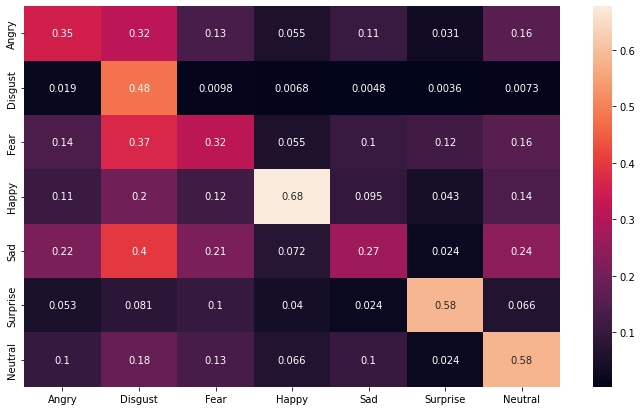

In [71]:
# Build confusion matrix
cf_matrix = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix, axis=1), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [72]:
print(classification_report(y, y_pred, digits=7))
metrics = classification_report(y, y_pred, digits=7, output_dict=True)

print("Accuratezza generale del modello:", f"{round(metrics['accuracy'], 3)}%")
print("Precisione media del modello:", f"{round(metrics['weighted avg']['precision'], 3)}%")
print("Recall media del modello:", f"{round(metrics['weighted avg']['recall'], 3)}%")
print("F1-Score medio del modello:", f"{round(metrics['weighted avg']['f1-score'], 3)}%")

              precision    recall  f1-score   support

           0  0.3576720 0.3528184 0.3552286       958
           1  0.2366071 0.4774775 0.3164179       111
           2  0.3107722 0.3186706 0.3146718      1023
           3  0.6966357 0.6773830 0.6868745      1773
           4  0.3811149 0.2686447 0.3151458      1247
           5  0.7023121 0.5848375 0.6382141       831
           6  0.4317498 0.5823195 0.4958564      1233

    accuracy                      0.4817447      7176
   macro avg  0.4452663 0.4660216 0.4460584      7176
weighted avg  0.4895746 0.4817447 0.4807557      7176

Accuratezza generale del modello: 0.482%
Precisione media del modello: 0.49%
Recall media del modello: 0.482%
F1-Score medio del modello: 0.481%


In [73]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())
counter = 0 
# append all the conv layers and their respective weights to the list
for sequence in model_children:
    if type(sequence) == torch.nn.Sequential:
        for layer in sequence:
            if type(layer) == torch.nn.Conv2d:
                counter += 1
                model_weights.append(layer.weight)
                conv_layers.append(layer)

print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [74]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([16, 1, 3, 3])
CONV: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([32, 16, 3, 3])


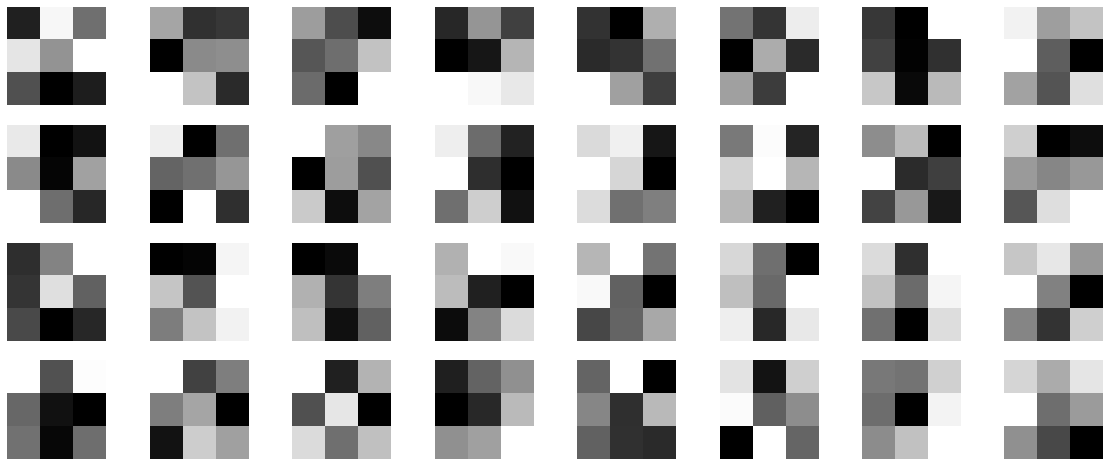

In [75]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('imgs_filter/second_cnn.png')
plt.show()

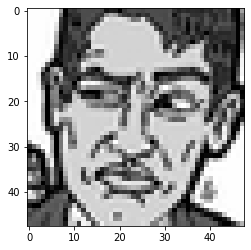

torch.Size([1, 48, 48])
torch.Size([1, 1, 48, 48])


In [76]:
img = test_set.pixels[0][0]
plt.imshow(img*255, cmap="gray")
plt.show()
# define the transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [77]:
print(conv_layers[0])

Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [78]:
# pass the image through all the layers
results = [conv_layers[0](torch.tensor(test_set.pixels)[:1].cuda())]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [79]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(48, 48))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./imgs_filter/layer_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([16, 48, 48])
Saving layer 0 feature maps...
torch.Size([32, 46, 46])
Saving layer 1 feature maps...
